# Lagrangian particle demonstration in a periodic domain.

**Particles are simulated in the Southern Ocean AVISO altimetrey velocity field.**

Author: Wenrui Jiang, Tom Haine Feb '23

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

import seaduck as sd

### Loading data

The AVISO velocity field dataset is a lat-lon grid with staggered velocity. It's a snapshot from a single time (see below). `seaduck.utils` provides a few datasets for testing and demonstration purposes. The corresponding dataset are called when the corresponding functions are called.

<div class="alert alert-block alert-warning">
<b>Download:</b> If you are running this notebook for the first time, The dataset needs to be downloaded and cached, which can be a little slow.
</div>

In [2]:
ds = sd.utils.get_dataset("aviso")
ds

<xarray.Dataset>
Dimensions:  (X: 3600, Xp1: 3600, Y: 300, Yp1: 300, time: 1)
Coordinates:
  * X        (X) float32 -179.9 -179.8 -179.7 -179.6 ... 179.7 179.8 179.9 180.0
  * Xp1      (Xp1) float32 -179.9 -179.9 -179.8 -179.6 ... 179.8 179.9 179.9
  * Y        (Y) float32 -74.9 -74.8 -74.7 -74.6 ... -45.3 -45.2 -45.1 -45.0
  * Yp1      (Yp1) float32 -74.95 -74.85 -74.75 -74.65 ... -45.25 -45.15 -45.05
  * time     (time) datetime64[ns] 2017-01-01
Data variables:
    lat      (Y) float32 ...
    lon      (X) float32 ...
    u        (Yp1, X) float16 ...
    v        (Y, Xp1) float16 ...
Attributes: (12/42)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         aviso@altimetry.fr
    creator_email:                   aviso@altimetry.fr
    ...                              ...
    summary:                         CLS Delayed-Time Level-4 sea surface hei...
    time_coverage_duration:          P1D
    time_coverage_end:               2017-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2016-12-31T12:00:00Z
    title:                           DT merged all satellites Global Gridded ...

Now, create the `OceData` object which provides methods to translate between lat-lon and grid-oriented coords. The model coords frequently needed are also cached. 

In [3]:
bathtub = sd.OceData(ds)

The object also contains a `tp` (topology) object. It looks at the shape of the coordinate data. In this case, based on longitude range, it thinks the type is `x_periodic`, which is correct for the Southern Ocean.

In [4]:
bathtub.tp.typ

'x_periodic'

We've prepared the bathtub that the ducks are going to swim (passively drift) in. Now decide where and when to drop them. 

We are going to use a short-hand defined in `seaduck.utils` to define the initial position for simplicity. The returns are normal than four 1D `numpy` array of `lon, lat, dep`, and `time`. It is as simple as that.

In [5]:
# Define the extend of the box
east = -180.0
west = 180.0
south = -75.0
north = -40.0
shallow = -10.0
deep = -10.0

time = "1970-01-01"

Nlon = 300  # How many along longitudinal direction?
Nlat = 30  # How many along latitudinal direction?
Ndep = 1  # How many along vertical direction?

x, y, z, t = sd.utils.easy_3d_cube(
    (east, west, Nlon),
    (south, north, Nlat),
    (shallow, deep, Ndep),
    time,
    print_total_number=True,
)

A total 9000 positions defined.


**Here is where the particles start on the map:**

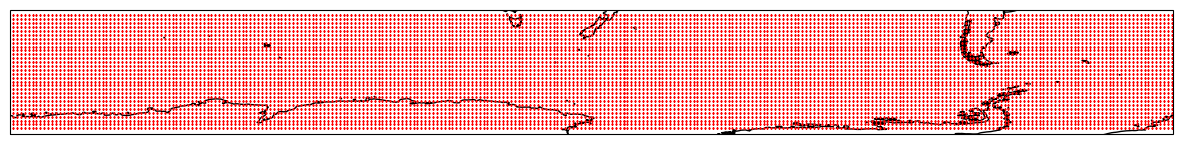

In [6]:
plt.figure(figsize=(15, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=170.0))
ax.plot(x, y, "r+", markersize=1, transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

The AVISO velocity data only has the horizontal velocity component. Or in other words, all the particles are assume to be at the same (implicit) level, which is the surface for this example. `seaduck` takes care of that by just setting:

In [7]:
z = None

The AVISO velocity field is a snapshot and does not have a time dimension. Therefore, the time is only valid in a relative sense, i.e. how long has the simulation gone in "real" time.

The standard format for time in `seaduck` is seconds since `1970-01-01 00:00` and could be negative. Remember what time is set as the initial time?

In [8]:
all(t == 0)

True

Let's now define the duration of the simulation (end before start means integrate backwards in time). We can again use a short hand from `seaduck.utils`.

In [9]:
tf = sd.utils.convert_time("1970-02-01")

This is equivalent to:

We are only interested when the particle is still in the domain, we can disregard the ones left from the northern boundary by defining:

In [10]:
def interested_in(p):
    return np.logical_and(-74.5 < p.lat, p.lat < -45.5)

### Now create the `OceInterp.lagrangian.particle` object.

We have all the information we need. The final step of preparation is to create the `seaduck.lagrangian.particle` object. We need to tell the `seaduck` where, when, which bathtub, as well as the name of the velocity components, because they are not great at guessing.

In [11]:
p = sd.particle(
    x=x,
    y=y,
    z=z,
    t=t,
    data=bathtub,
    uname="u",
    vname="v",
    wname=None,
    callback=interested_in,
)
p

### Perform the particle trajectory simulation.

Notice how we define when to dump output (`normal_stops`) and when to update the velocity field (`update_stops`). By default, the `stops` returned by the integration is the combination (union) of `normal_stops` and `update_stops`. `raw` is a list of `OceInterp.eulerian.position` objects with the same length as `stops`.

In [12]:
normal_stops = np.linspace(t[0], tf, 10)
stops, raw = p.to_list_of_time(normal_stops=normal_stops, update_stops=[])

1970-01-01T00:00:00
0 left       
1970-01-04T10:40:00
0 left         
1970-01-07T21:20:00
0 left         
1970-01-11T08:00:00
0 left         
1970-01-14T18:40:00
0 left         
1970-01-18T05:20:00
0 left         
1970-01-21T16:00:00
0 left         
1970-01-25T02:40:00
0 left         
1970-01-28T13:20:00
0 left         
1970-02-01T00:00:00
0 left         


### Extract the information from the position objects.

In [13]:
lons = np.array([pt.lon for pt in raw]).T
lats = np.array([pt.lat for pt in raw]).T

Some particles passed through the dateline (periodic boundary). Here is some pre-processing to handle the plot.

In [14]:
for i in range(len(lons)):
    diff = np.diff(lons[i])

    if max(abs(diff)) > 330:
        for j in np.where(abs(diff) > 300)[0]:
            j = int(j)
            lons[i, j + 1 :] -= np.sign(diff[j]) * 360

## Here are the trajectories:

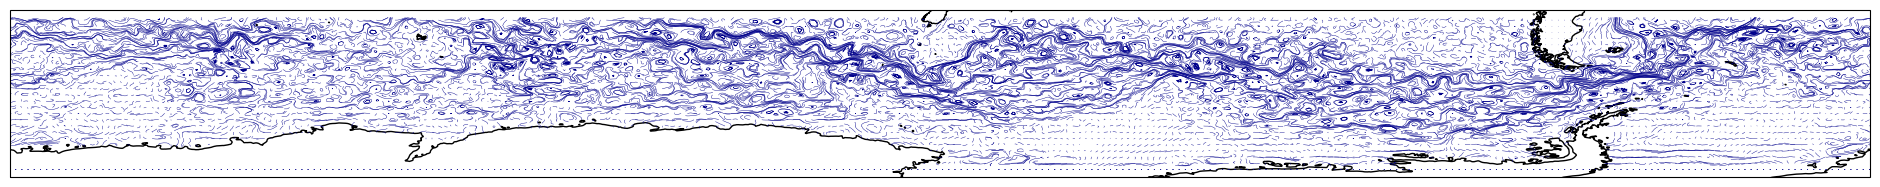

In [15]:
plt.figure(figsize=(24, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=170.0))
ax.plot(lons.T, lats.T, "darkblue", lw=0.3, transform=ccrs.PlateCarree())
ax.coastlines()